# SHAP on ENSEMBLE

In [1]:
#!/usr/bin/env python
# coding: utf-8
import os.path
import warnings
warnings.filterwarnings("ignore")

from scipy.io import loadmat
import numpy as np
from numpy.random import seed
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette='muted')
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import shap
shap.initjs()

from tqdm import tqdm

import torch
from torch import Tensor
import torchsummary
from torch.nn import MSELoss, L1Loss
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ExponentialLR

from python.plot_utils import *
from python.regression_utils import cnn_prediction
from python.torch_utils import *
from python.architecture_pytorch import IPA

SEED_VALUE = 1
seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
fontsize = 25
plt.rc('font', size=fontsize*.8) #controls default text size
plt.rc('axes', titlesize=fontsize) #fontsize of the title
plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize/1.5) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize/1.5) #fontsize of the y tick labels
plt.rc('legend', fontsize=fontsize/1.5) #fontsize of the legend

In [3]:
PLS_vip = loadmat("data/pls_vip_scores.mat")['vipScore']

## Loading data and model

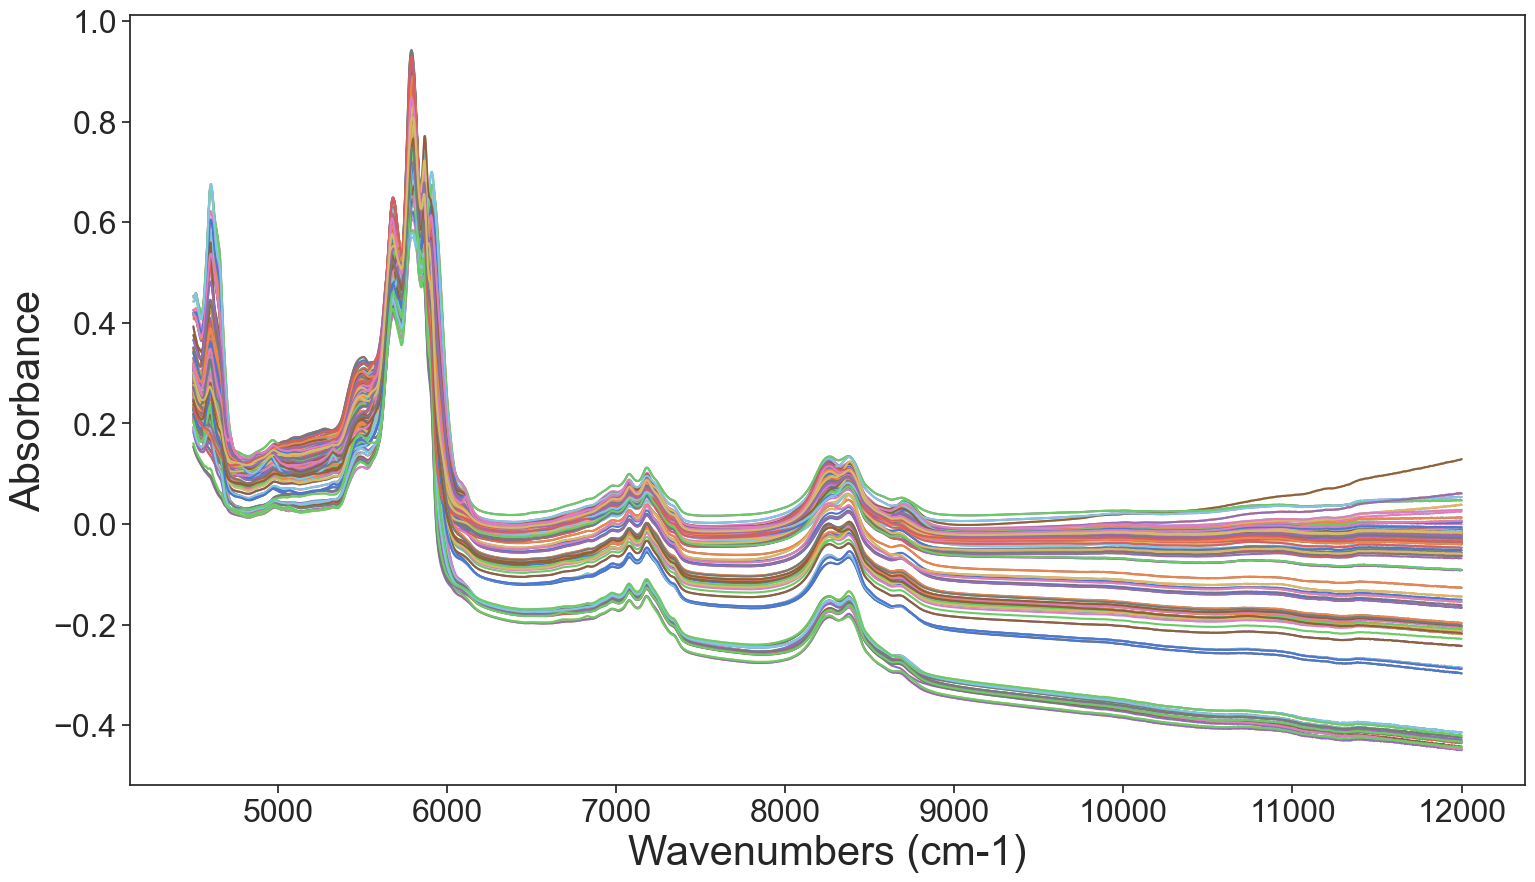

In [4]:
""" MODEL LOGISTICS """
MODEL_NAME_BASE = 'IPA-Torch'
path_model = 'model/'

""" BASE HPs """
batch_size = 16
n_epochs = 500
initial_lr = .00025

""" REGULARIZATION HPs """
l2_lambda = .001
decay_steps, decay_rate = 10000, 0.001 # Lr scheduler HPs

data = loadmat("data/raw-kennard-reduced_range.mat")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
W = data['Wcal'][0]


def plot_df(values, xlabel, fontsize=30, nbr_of_ticks=25):
    df = pd.DataFrame(values)
    df.columns = xlabel.T
    _, ax = plt.subplots(1, figsize=(18,10))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize-7)

    ax.plot(df.transpose())
    plt.xlabel('Wavenumbers (cm-1)', fontsize=fontsize)
    plt.ylabel("Absorbance", fontsize=fontsize)
    plt.show()

plot_df(np.concatenate([X_train, X_test]), W)

In [5]:
scalerX = StandardScaler()
scalerY = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)
y_train_scaled = scalerY.fit_transform(y_train)
y_test_scaled = scalerY.transform(y_test)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

X_train_reshaped = X_train.unsqueeze(1)
X_test_reshaped = X_test.unsqueeze(1)

train_loader = create_dataloader(X_train_reshaped, y_train, batch_size)
test_loader = create_dataloader(X_test_reshaped, y_test, batch_size)

In [6]:
n_ensemble = 10

import pathlib
from time import time

def build_IPA(output_dims=1):
    model = IPA().to(device)
    model = init_weights(model)
    return model

In [7]:
ensemble = [build_IPA(output_dims=1) for _ in range(n_ensemble)]
ensemble = torch.nn.ModuleList(ensemble)

path_model_prefix = "saved_models"
path_model = f"{path_model_prefix}/ensemble_{len(ensemble)}-{MODEL_NAME_BASE}.pt"
ensemble_file = pathlib.Path(path_model)

if ensemble_file.exists():
    print(f"Ensemble exists, loading ensemble from: '{ensemble_file}'")
    ensemble.load_state_dict(torch.load(path_model))

else: 
    print('Ensemble does not exists, training ensemble')
    start_time = time()
    optimizers = []
    criterion = nn.L1Loss()
    criterion_test = nn.MSELoss()
    lr_schedulers = []
    
    ensemble_train_loss = []
    ensemble_test_loss = []
    
    for model in ensemble:
        optimizers.append(optim.Adam(model.parameters(), lr=initial_lr))
        lr_schedulers.append(ExponentialLR(optimizers[-1], gamma=(1 - decay_rate) ** (1 / decay_steps)))
        
        model_train_loss = []
        model_test_loss = []
    
        for epoch in tqdm(range(n_epochs), desc='Epochs', unit='epoch'):
            model.train()
            optimizer, lr_scheduler = optimizers[-1], lr_schedulers[-1]
            for batch, (X, y) in enumerate(train_loader):
                optimizer.zero_grad()
                X, y = X.to(device), y.to(device)
                y_preds = model(X)
                train_loss = criterion(y_preds, y)
                train_loss = kernel_regularization(model, train_loss, l2_lambda)
        
                train_loss.backward()
                optimizer.step()
                lr_scheduler.step()
    
            for batch, (X, y) in enumerate(test_loader):
                num_batches = len(test_loader)
                model.eval()
                with torch.no_grad():
                    X, y = X.to(device), y.to(device)
                    y_preds = model(X)
                    test_loss = criterion_test(y_preds, y)
    
            model_train_loss.append(train_loss.detach().cpu())
            model_test_loss.append(test_loss.detach().cpu())
    
        ensemble_train_loss.append(model_train_loss)
        ensemble_test_loss.append(model_test_loss)

    end_time = time()
    pathlib.Path(path_model_prefix).mkdir(exist_ok=True)
    torch.save(ensemble.state_dict(), path_model)

    total_time = end_time - start_time
    print(f'{total_time / 60:.2f} min')

    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    for loss, idx in zip(ensemble_train_loss, range(0, len(ensemble_train_loss))): 
        axs[0].plot(loss, label=f'IPA-train_{idx+1}')
    axs[0].set_ylim(ymin=0)
    axs[0].set_title('Train - MAE')
    
    for loss, idx in zip(ensemble_test_loss, range(0, len(ensemble_test_loss))):
        axs[1].plot(loss, label=f'IPA-test_{idx+1}')
    axs[1].set_ylim(ymin=0)
    axs[1].set_title('Test - MSE')

Ensemble exists, loading ensemble from: 'saved_models\ensemble_10-IPA-Torch.pt'


In [8]:
def compute_moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [9]:
# input_sample = X_train.unsqueeze(1)[:]
input_sample = X_train_reshaped
print(input_sample.shape)

SHAP_ensemble = []
for model in ensemble:
    ex = shap.DeepExplainer(model, input_sample)
    shapley_values_raw = ex.shap_values(input_sample)
    shap_values = shapley_values_raw.squeeze(1)
    SHAP_ensemble.append(shap_values)
SHAP_ensemble = np.array(SHAP_ensemble)
print(SHAP_ensemble.shape)

torch.Size([174, 1, 3890])
(10, 174, 3890)


In [10]:
processed_SHAP = []
window = 50
moving_average_W = []

for shap_values in SHAP_ensemble:
    mean_absolute_features = np.average(np.abs(shap_values), axis=0)
    moving_average_features = compute_moving_average(mean_absolute_features, window)
    moving_average_W = compute_moving_average(W, window)
    processed_SHAP.append(moving_average_features)
processed_SHAP = np.array(processed_SHAP)
print(processed_SHAP.shape)

SHAP_ensemble_mu = np.mean(np.abs(processed_SHAP), axis=0)
SHAP_ensemble_std = np.std(np.abs(processed_SHAP), axis=0)

(10, 3841)


Text(0, 0.5, 'Absolute SVs')

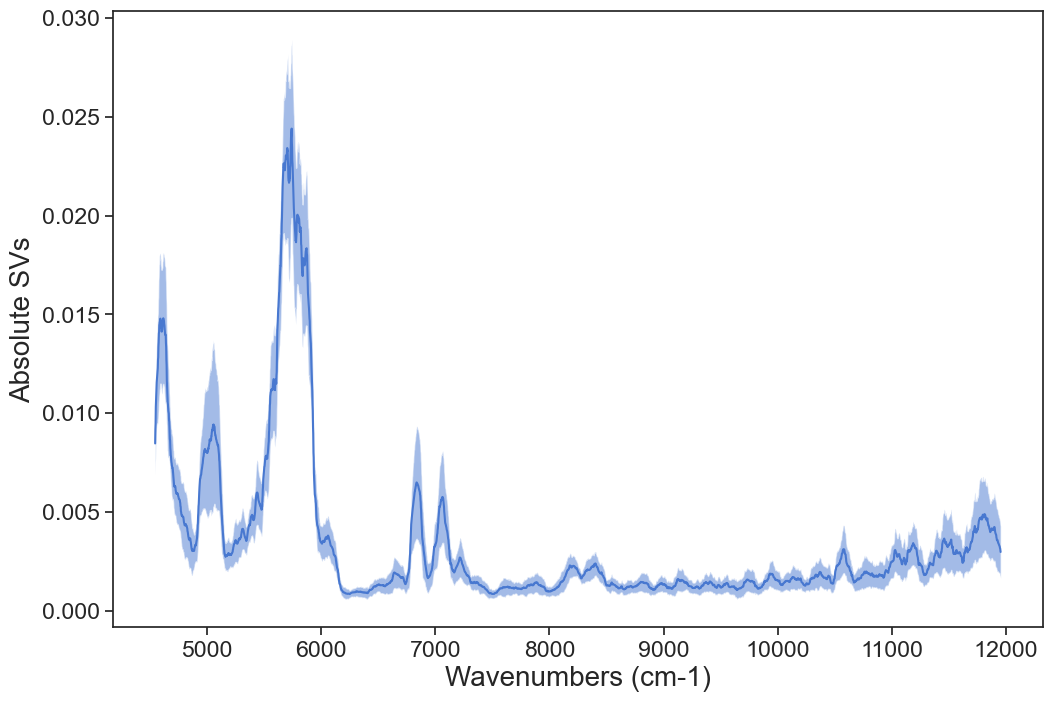

In [12]:
_, ax = plt.subplots(1, figsize=(12,8))
sns.lineplot(y=SHAP_ensemble_mu, x=moving_average_W)
plt.fill_between(moving_average_W, SHAP_ensemble_mu - SHAP_ensemble_std, SHAP_ensemble_mu + SHAP_ensemble_std, alpha=.5)
plt.xlabel("Wavenumbers (cm-1)", fontsize=20)
plt.ylabel("Absolute SVs", fontsize=20)